In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# File paths

In [ ]:
model_path = "/content/drive/MyDrive/CNXSIA001_LAIDS_SOURCE_CODE/AE-MLP Model Files/Models"
dataset_path =  "/content/drive/MyDrive/CNXSIA001_LAIDS_SOURCE_CODE/AE-MLP Model Files/Datasets and Numpy Arrays"

# Load Training & Test Data

In [ ]:
import pandas as pd
from collections import Counter
import os

# Training sets
ae_X_train = pd.read_csv(os.path.join(dataset_path, "ae_x_train.csv")).to_numpy()
ae_y_train = pd.read_csv(os.path.join(dataset_path, "ae_y_train.csv")).to_numpy().ravel()

# Validation sets
ae_X_val = pd.read_csv(os.path.join(dataset_path, "ae_x_val.csv")).to_numpy()
ae_y_val = pd.read_csv(os.path.join(dataset_path, "ae_y_val.csv")).to_numpy().ravel()

# # Classifier training sets
mlp_X_train = pd.read_csv(os.path.join(dataset_path, "adasyn_mlp_x_train.csv")).to_numpy() # MLP training data augumented using adasyn
mlp_y_train = pd.read_csv(os.path.join(dataset_path, "adasyn_mlp_y_train.csv")).to_numpy().ravel()

# Classifier validation sets
mlp_X_val = pd.read_csv(os.path.join(dataset_path, "mlp_x_val.csv")).to_numpy()
mlp_y_val = pd.read_csv(os.path.join(dataset_path, "mlp_y_val.csv")).to_numpy().ravel()

# Test sets
X_test = pd.read_csv(os.path.join(dataset_path, "ae_mlp_x_test.csv")).to_numpy()
y_test = pd.read_csv(os.path.join(dataset_path, "ae_mlp_y_test.csv")).to_numpy().ravel()

#Encoding map
attack_type_map = {'Normal Traffic': 0, 'Port Scanning': 1, 'Web Attacks': 2, 'Brute Force': 3, 'DDoS': 4, 'Bots': 5, 'DoS': 6} # Create a mapping from attack type to integer label


def print_class_distribution(y, name):
    counter = Counter(y)
    print(f"\n{name} class distribution:")
    for cls, cnt in counter.items():
        print(f"  Class {cls}: {cnt} samples")

print_class_distribution(ae_y_train, "AE_y_train")
print_class_distribution(ae_y_val, "AE_y_val")
print_class_distribution(mlp_y_train , "mlp_y_train")
print_class_distribution(mlp_y_val, "mlp_y_val")
print_class_distribution(y_test, "y_test")



AE_y_train class distribution:
  Class 0: 1357596 samples

AE_y_val class distribution:
  Class 0: 150844 samples

mlp_y_train class distribution:
  Class 5: 301702 samples
  Class 0: 301688 samples
  Class 6: 301889 samples
  Class 1: 301212 samples
  Class 3: 301697 samples
  Class 4: 301715 samples
  Class 2: 301702 samples

mlp_y_val class distribution:
  Class 0: 75423 samples
  Class 4: 20482 samples
  Class 1: 14511 samples
  Class 6: 30999 samples
  Class 3: 1464 samples
  Class 5: 312 samples
  Class 2: 343 samples

y_test class distribution:
  Class 0: 209506 samples
  Class 1: 18139 samples
  Class 6: 38749 samples
  Class 4: 25603 samples
  Class 3: 1830 samples
  Class 5: 389 samples
  Class 2: 429 samples


Encode the labels

In [ ]:
# --- Label Encoding ---
attack_type_map = {'Normal Traffic': 0, 'Port Scanning': 1, 'Web Attacks': 2, 'Brute Force': 3, 'DDoS': 4, 'Bots': 5, 'DoS': 6} # Create a mapping from attack type to integer label


#Load in FP32 Models

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import load_model
import numpy as np

# --- Load AE model ---
ae_model_path = os.path.join(model_path, 'Best_AE.keras')
ae_model = tf.keras.models.load_model(ae_model_path)
ae_model_name_prefix = os.path.join(model_path, 'Best_AE')

# --- Load in per feature thresholds ---
per_feature_thresholds_path = os.path.join(dataset_path,'ae_per_feature_thresholds.npy')
per_feature_thresholds = np.load(per_feature_thresholds_path)

# --- MLP model ---
mlp_model_path = os.path.join(model_path, 'Best_MLP.keras')
mlp_model = tf.keras.models.load_model(mlp_model_path)
mlp_model_name_prefix = os.path.join(model_path, 'Best_MLP')

# Dynamic Range Quantisation (Weight-only quantisation)

Autoencoder

In [ ]:
import tensorflow as tf
from tensorflow import keras
import os # Import os for path joining

# --- Float32 baseline (no quantisation) ---
converter = tf.lite.TFLiteConverter.from_keras_model(ae_model)
print("# --- AE Float32 baseline (no quantisation) ---")
ae_quantModel_f32 = converter.convert() # Convert model

# --- Weight-only quantisation (int8 weights, float32 activations) ---
converter = tf.lite.TFLiteConverter.from_keras_model(ae_model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]  # triggers int8 weight quantisation
print("# --- AE Weight-only quantisation (int8 weights, float32 activations) ---")
ae_quantModel_int8_weights = converter.convert()# Convert model

# --- Weight-only quantisation (float16 weights, float32 activations) ---
converter = tf.lite.TFLiteConverter.from_keras_model(ae_model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
converter.target_spec.supported_types = [tf.float16]  # store weights as float16
print("# --- AE Weight-only quantisation (float16 weights, float32 activations) ---")
ae_quantModel_fp16_weights = converter.convert()# Convert model

# --- Save models ---
ae_float32_path = ae_model_name_prefix + '_float32.tflite'
with open(ae_float32_path, 'wb') as f:
    f.write(ae_quantModel_f32)
print(f"AE Float32 model saved to: {os.path.abspath(ae_float32_path)}")

ae_int8_weights_path = ae_model_name_prefix + '_int8_weights.tflite'
with open(ae_int8_weights_path, 'wb') as f:
    f.write(ae_quantModel_int8_weights)
print(f"AE Int8 Weights-Only model saved to: {os.path.abspath(ae_int8_weights_path)}")

ae_fp16_weights_path = ae_model_name_prefix + '_fp16_weights.tflite'
with open(ae_fp16_weights_path, 'wb') as f:
    f.write(ae_quantModel_fp16_weights)
print(f"AE Float16 Weights-Only model saved to: {os.path.abspath(ae_fp16_weights_path)}")

# --- AE Float32 baseline (no quantization) ---
Saved artifact at '/tmp/tmp1hgurqi_'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 52), dtype=tf.float32, name='input_layer')
Output Type:
  TensorSpec(shape=(None, 52), dtype=tf.float32, name=None)
Captures:
  132589077348176: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132589077347216: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132589074596880: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132589074597648: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132589074596112: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132589074598608: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132589074598224: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132589074599184: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132589074600912: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132589074601488: TensorSpec(shape=(), dtype=t

MLP

In [ ]:
import tensorflow as tf
from tensorflow import keras
import os # Import os for path joining

# --- MLP Float32 baseline (no quantisation) ---
converter = tf.lite.TFLiteConverter.from_keras_model(mlp_model)
print("# --- MLP Float32 baseline (no quantisation) ---")
mlp_quantModel_f32 = converter.convert()# Convert model

# --- MLP Weight-only quantisation (int8 weights, float32 activations) ---
converter = tf.lite.TFLiteConverter.from_keras_model(mlp_model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]  # triggers int8 weight quantisation
print("# --- MLP Weight-only quantisation (int8 weights, float32 activations) ---")
mlp_quantModel_int8_weights = converter.convert()# Convert model

# --- MLP Weight-only quantisation (float16 weights, float32 activations) ---
converter = tf.lite.TFLiteConverter.from_keras_model(mlp_model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
converter.target_spec.supported_types = [tf.float16]  # store weights as float16
print("# --- MLP Weight-only quantisation (float16 weights, float32 activations) ---")
mlp_quantModel_fp16_weights = converter.convert()# Convert model

# --- Save models ---
mlp_float32_path = mlp_model_name_prefix + '_float32.tflite'
with open(mlp_float32_path, 'wb') as f:
    f.write(mlp_quantModel_f32)
print(f"MLP Float32 model saved to: {os.path.abspath(mlp_float32_path)}")

mlp_int8_weights_path = mlp_model_name_prefix + '_int8_weights.tflite'
with open(mlp_int8_weights_path, 'wb') as f:
    f.write(mlp_quantModel_int8_weights)
print(f"MLP Int8 Weights-Only model saved to: {os.path.abspath(mlp_int8_weights_path)}")

mlp_fp16_weights_path = mlp_model_name_prefix + '_fp16_weights.tflite'
with open(mlp_fp16_weights_path, 'wb') as f:
    f.write(mlp_quantModel_fp16_weights)
print(f"MLP Float16 Weights-Only model saved to: {os.path.abspath(mlp_fp16_weights_path)}")

# --- MLP Float32 baseline (no quantization) ---
Saved artifact at '/tmp/tmpnx4n0avx'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 52), dtype=tf.float32, name='input_layer_1')
Output Type:
  TensorSpec(shape=(None, 7), dtype=tf.float32, name=None)
Captures:
  132589074605136: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132589007733008: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132589007736080: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132589007735120: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132589007736272: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132589007736848: TensorSpec(shape=(), dtype=tf.resource, name=None)
# --- MLP Weight-only quantization (int8 weights, float32 activations) ---
Saved artifact at '/tmp/tmpwb70ibbx'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 52), dtype=tf.float32, name='in

# Evaluation of weight-only quant models (Dynamic Range Quantization)

Imports

In [ ]:
# --- Imports ---
import os
import psutil
import time
import resource
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf

from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
from tensorflow.keras.models import load_model, Sequential
from tensorflow.keras import layers, regularizers
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout, BatchNormalization

Create model dictionary

In [ ]:
# List of TFLite models (AE -> MLP)
tflite_models = [
    {
        "ae_model": ae_quantModel_f32,
        "ae_name": "AE Float32 Model",
        "mlp_model": mlp_quantModel_f32,
        "mlp_name": "MLP Float32 Model",
    },
    {
        "ae_model": ae_quantModel_fp16_weights,
        "ae_name": "AE Float16 Weights-Only Model",
        "mlp_model": mlp_quantModel_fp16_weights,
        "mlp_name": "MLP Float16 Weights-Only Model",
    },
    {
        "ae_model": ae_quantModel_int8_weights,
        "ae_name": "AE Int8 Weights-Only Model",
        "mlp_model": mlp_quantModel_int8_weights,
        "mlp_name": "MLP Int8 Weights-Only Model",
    }
]


# Performance evaluation


 --- Evaluating AE: AE Float32 Model → MLP: MLP Float32 Model ---


/usr/local/lib/python3.12/dist-packages/tensorflow/lite/python/interpreter.py:457: UserWarning:     Warning: tf.lite.Interpreter is deprecated and is scheduled for deletion in
    TF 2.20. Please use the LiteRT interpreter from the ai_edge_litert package.
    See the [migration guide](https://ai.google.dev/edge/litert/migration)
    for details.
    
  warnings.warn(_INTERPRETER_DELETION_WARNING)


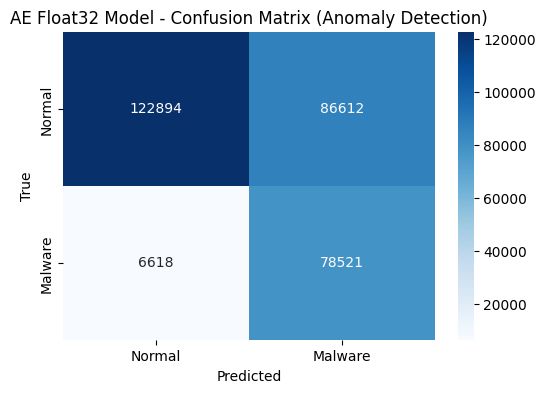

Accuracy: 0.47437764088988443
Classification Report:
              precision    recall  f1-score   support

      Normal       0.95      0.59      0.72    209506
     Malware       0.48      0.92      0.63     85139

    accuracy                           0.68    294645
   macro avg       0.71      0.75      0.68    294645
weighted avg       0.81      0.68      0.70    294645


TP, TN, FP, FN for Malware vs Benign:
True Positives (Malware predicted as ANY malware): 78521 (92.22682906775978% of Malware Identified)
True Negatives (Benign predicted as Benign): 122894
False Positives (Benign predicted as Malware): 86612 (41.341059444598244% of Benign Misclassified)
False Negatives (Malware predicted as Benign): 6618

--- Malware vs Benign Performance Metrics ---
Accuracy: 0.6836
Precision (Malware): 0.4755
Recall / Sensitivity (Malware): 0.9223
F1-Score (Malware): 0.6275
False Positive Rate (Benign misclassified): 41.34%
False Negative Rate (Malware missed): 7.77%


/usr/local/lib/python3.12/dist-packages/tensorflow/lite/python/interpreter.py:457: UserWarning:     Warning: tf.lite.Interpreter is deprecated and is scheduled for deletion in
    TF 2.20. Please use the LiteRT interpreter from the ai_edge_litert package.
    See the [migration guide](https://ai.google.dev/edge/litert/migration)
    for details.
    
  warnings.warn(_INTERPRETER_DELETION_WARNING)


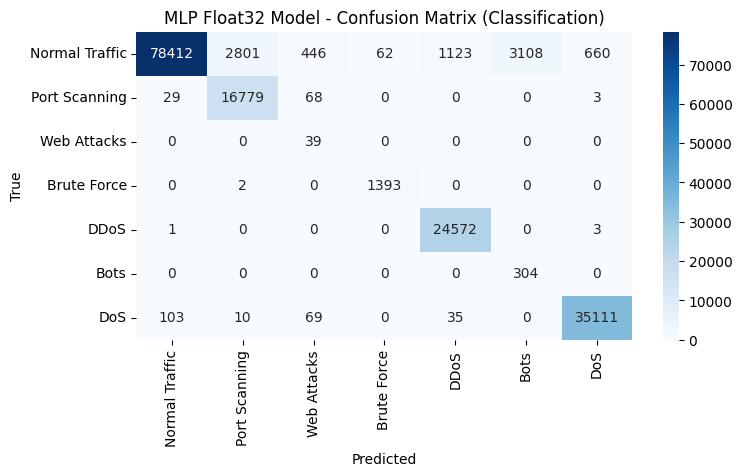

Accuracy: 0.9483870577050014
Classification Report:
                precision    recall  f1-score   support

Normal Traffic       1.00      0.91      0.95     86612
 Port Scanning       0.86      0.99      0.92     16879
   Web Attacks       0.06      1.00      0.12        39
   Brute Force       0.96      1.00      0.98      1395
          DDoS       0.95      1.00      0.98     24576
          Bots       0.09      1.00      0.16       304
           DoS       0.98      0.99      0.99     35328

      accuracy                           0.95    165133
     macro avg       0.70      0.98      0.73    165133
  weighted avg       0.97      0.95      0.96    165133

Total Mal: 78521 & 78521
Total Malware Samples: 78521
Total Benign Samples: 86612

TP, TN, FP, FN for Malware vs Benign:
True Positives (Malware predicted as ANY malware): 78388 (99.83% of Malware Identified)
True Negatives (Benign predicted as Benign): 78412 (90.53% of Benign Identified)
False Positives (Benign predicted as Ma

/usr/local/lib/python3.12/dist-packages/tensorflow/lite/python/interpreter.py:457: UserWarning:     Warning: tf.lite.Interpreter is deprecated and is scheduled for deletion in
    TF 2.20. Please use the LiteRT interpreter from the ai_edge_litert package.
    See the [migration guide](https://ai.google.dev/edge/litert/migration)
    for details.
    
  warnings.warn(_INTERPRETER_DELETION_WARNING)


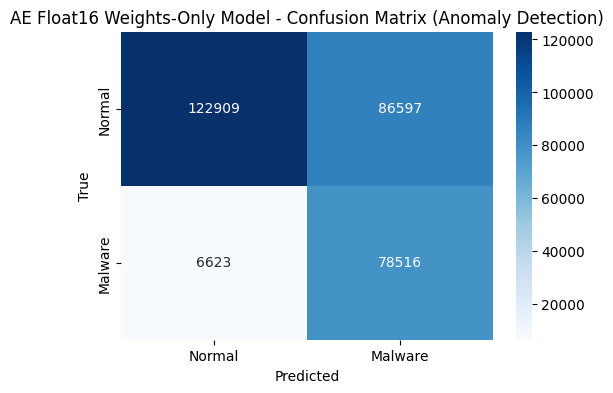

Accuracy: 0.47442176178112644
Classification Report:
              precision    recall  f1-score   support

      Normal       0.95      0.59      0.73    209506
     Malware       0.48      0.92      0.63     85139

    accuracy                           0.68    294645
   macro avg       0.71      0.75      0.68    294645
weighted avg       0.81      0.68      0.70    294645


TP, TN, FP, FN for Malware vs Benign:
True Positives (Malware predicted as ANY malware): 78516 (92.22095631849095% of Malware Identified)
True Negatives (Benign predicted as Benign): 122909
False Positives (Benign predicted as Malware): 86597 (41.3338997451147% of Benign Misclassified)
False Negatives (Malware predicted as Benign): 6623

--- Malware vs Benign Performance Metrics ---
Accuracy: 0.6836
Precision (Malware): 0.4755
Recall / Sensitivity (Malware): 0.9222
F1-Score (Malware): 0.6275
False Positive Rate (Benign misclassified): 41.33%
False Negative Rate (Malware missed): 7.78%


/usr/local/lib/python3.12/dist-packages/tensorflow/lite/python/interpreter.py:457: UserWarning:     Warning: tf.lite.Interpreter is deprecated and is scheduled for deletion in
    TF 2.20. Please use the LiteRT interpreter from the ai_edge_litert package.
    See the [migration guide](https://ai.google.dev/edge/litert/migration)
    for details.
    
  warnings.warn(_INTERPRETER_DELETION_WARNING)


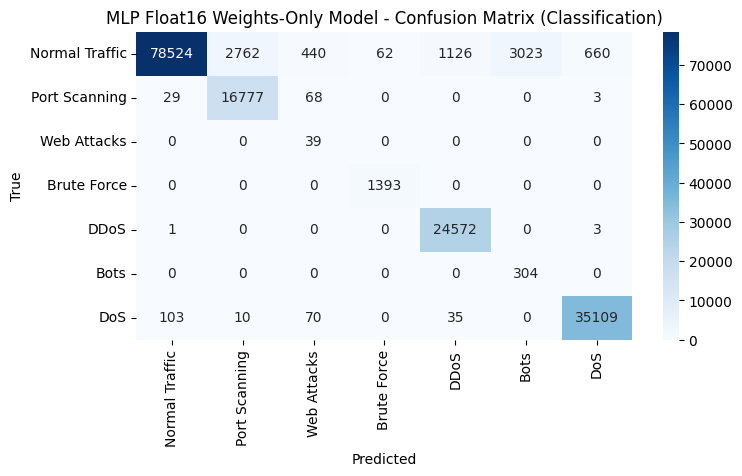

Accuracy: 0.949156032535294
Classification Report:
                precision    recall  f1-score   support

Normal Traffic       1.00      0.91      0.95     86597
 Port Scanning       0.86      0.99      0.92     16877
   Web Attacks       0.06      1.00      0.12        39
   Brute Force       0.96      1.00      0.98      1393
          DDoS       0.95      1.00      0.98     24576
          Bots       0.09      1.00      0.17       304
           DoS       0.98      0.99      0.99     35327

      accuracy                           0.95    165113
     macro avg       0.70      0.98      0.73    165113
  weighted avg       0.97      0.95      0.96    165113

Total Mal: 78516 & 78516
Total Malware Samples: 78516
Total Benign Samples: 86597

TP, TN, FP, FN for Malware vs Benign:
True Positives (Malware predicted as ANY malware): 78383 (99.83% of Malware Identified)
True Negatives (Benign predicted as Benign): 78524 (90.68% of Benign Identified)
False Positives (Benign predicted as Mal

/usr/local/lib/python3.12/dist-packages/tensorflow/lite/python/interpreter.py:457: UserWarning:     Warning: tf.lite.Interpreter is deprecated and is scheduled for deletion in
    TF 2.20. Please use the LiteRT interpreter from the ai_edge_litert package.
    See the [migration guide](https://ai.google.dev/edge/litert/migration)
    for details.
    
  warnings.warn(_INTERPRETER_DELETION_WARNING)


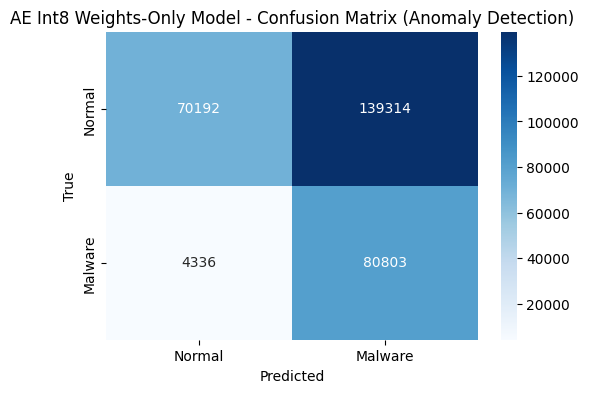

Accuracy: 0.2962785725194726
Classification Report:
              precision    recall  f1-score   support

      Normal       0.94      0.34      0.49    209506
     Malware       0.37      0.95      0.53     85139

    accuracy                           0.51    294645
   macro avg       0.65      0.64      0.51    294645
weighted avg       0.78      0.51      0.50    294645


TP, TN, FP, FN for Malware vs Benign:
True Positives (Malware predicted as ANY malware): 80803 (94.9071518340596% of Malware Identified)
True Negatives (Benign predicted as Benign): 70192
False Positives (Benign predicted as Malware): 139314 (66.49642492339122% of Benign Misclassified)
False Negatives (Malware predicted as Benign): 4336

--- Malware vs Benign Performance Metrics ---
Accuracy: 0.5125
Precision (Malware): 0.3671
Recall / Sensitivity (Malware): 0.9491
F1-Score (Malware): 0.5294
False Positive Rate (Benign misclassified): 66.50%
False Negative Rate (Malware missed): 5.09%


/usr/local/lib/python3.12/dist-packages/tensorflow/lite/python/interpreter.py:457: UserWarning:     Warning: tf.lite.Interpreter is deprecated and is scheduled for deletion in
    TF 2.20. Please use the LiteRT interpreter from the ai_edge_litert package.
    See the [migration guide](https://ai.google.dev/edge/litert/migration)
    for details.
    
  warnings.warn(_INTERPRETER_DELETION_WARNING)


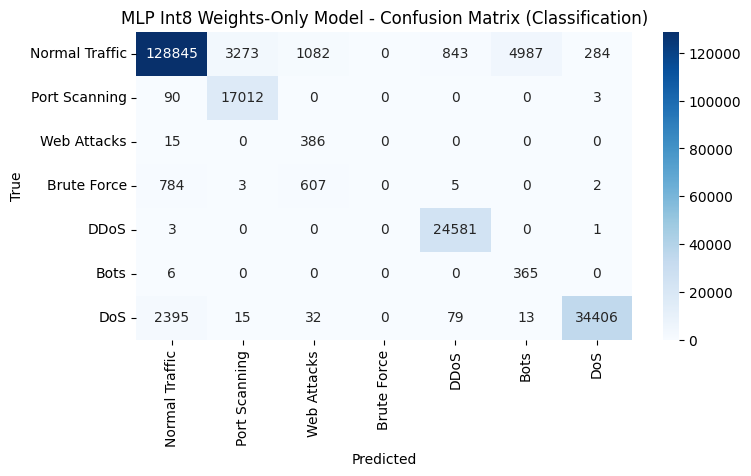

Accuracy: 0.9340259952661539
Classification Report:
                precision    recall  f1-score   support

Normal Traffic       0.98      0.92      0.95    139314
 Port Scanning       0.84      0.99      0.91     17105
   Web Attacks       0.18      0.96      0.31       401
   Brute Force       0.00      0.00      0.00      1401
          DDoS       0.96      1.00      0.98     24585
          Bots       0.07      0.98      0.13       371
           DoS       0.99      0.93      0.96     36940

      accuracy                           0.93    220117
     macro avg       0.57      0.83      0.61    220117
  weighted avg       0.96      0.93      0.94    220117

Total Mal: 80803 & 80803
Total Malware Samples: 80803
Total Benign Samples: 139314

TP, TN, FP, FN for Malware vs Benign:
True Positives (Malware predicted as ANY malware): 77510 (95.92% of Malware Identified)
True Negatives (Benign predicted as Benign): 128845 (92.49% of Benign Identified)
False Positives (Benign predicted as 

/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [ ]:
# Evaluate the models
for m in tflite_models: # Loop through the FP32, FP26 and Dynamic INT8 models
    ae_model_content = m["ae_model"]
    ae_name = m["ae_name"]

    mlp_model_content = m["mlp_model"]
    mlp_name = m["mlp_name"]

    print(f"\n --- Evaluating AE: {ae_name} → MLP: {mlp_name} ---")


    # -------------------
    # --- Autoencoder ---
    # -------------------

    # Loads the TFLite model and gets it ready to make predictions
    ae_interpreter = tf.lite.Interpreter(model_content=ae_model_content) # Create interpreter object that will read and run the TFLite model
    ae_interpreter.allocate_tensors() # Make the interpreter allocate memory
    ae_input_details = ae_interpreter.get_input_details() # Get expected shape and data type of the data the model needs to evaluate (built-in method)
    ae_output_details = ae_interpreter.get_output_details() # Shape and data type the model will need to produce the results in


    # Get model predictions for test sample
    ae_y_pred_probs = []

    for i in range(len(X_test)): # Interpreter object does not have a built-in .evaluate() method like the Keras Model object does, therefore need to go through every sample manually
        input_data = np.expand_dims(X_test[i], axis=0).astype(ae_input_details[0]['dtype']) # Reshape data for model: (1, number of features)
        ae_interpreter.set_tensor(ae_input_details[0]['index'], input_data) #Feed a single sample of input data into the TFLite interpreter
        ae_interpreter.invoke() # Tell the interpreter to run the model on the input data
        ae_output_data = ae_interpreter.get_tensor(ae_output_details[0]['index']) # Get the output from the model
        ae_y_pred_probs.append(ae_output_data[0]) # Add the raw output to the list
        # Run autoencoder on the entire test set at once

    ae_y_pred_probs = np.array(ae_y_pred_probs)
    test_reconstruction_errors = np.abs(ae_y_pred_probs - X_test)# Calc. reconstruction errors
    ae_y_pred = (test_reconstruction_errors > per_feature_thresholds).any(axis=1).astype(int)# Flag samples as anomalies based on per-feature thresholds

    malicious_pred_indices = np.flatnonzero(ae_y_pred)# Get indices of samples flagged as malicious


    # --- Confusion Matrix ---

    y_test_binary = (y_test != 0).astype(int)# Convert y_test to binary for AE: 0 = Normal, 1 = Malware

    ae_cm = confusion_matrix(y_test_binary, ae_y_pred) # Compute AE cinfusion matrix
    labels = ["Normal", "Malware"]

    # Plot heatmap
    plt.figure(figsize=(6, 4))
    sns.heatmap(ae_cm, annot=True, fmt="d", cmap="Blues", xticklabels=labels, yticklabels=labels)
    plt.title(f"{ae_name} - Confusion Matrix (Anomaly Detection)")
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.show()

    # --- Accuracy & Classification Report ---
    print("Accuracy:", accuracy_score(y_test, ae_y_pred))
    print("Classification Report:")
    print(classification_report(y_test_binary, ae_y_pred, target_names=labels, labels=[0, 1]))


    # --- Malware vs Benign Metrics ---
    # Confusion matrix layout (for binary classification):
    # [[TN, FP],
    #  [FN, TP]]
    tn, fp, fn, tp = ae_cm.ravel() # Get AE cm values

    total_malware = tp + fn
    total_benign = tn + fp

    malware_identified = tp
    benign_misclassified = fp

    percentage_malware_identified = (malware_identified / total_malware * 100) if total_malware > 0 else 0
    percentage_benign_misclassified = (benign_misclassified / total_benign * 100) if total_benign > 0 else 0

    print("\nTP, TN, FP, FN for Malware vs Benign:")
    print(f"True Positives (Malware predicted as ANY malware): {tp} ({percentage_malware_identified}% of Malware Identified)")
    print(f"True Negatives (Benign predicted as Benign): {tn}")
    print(f"False Positives (Benign predicted as Malware): {fp} ({percentage_benign_misclassified}% of Benign Misclassified)")
    print(f"False Negatives (Malware predicted as Benign): {fn}")

    # --- Performance Metrics ---
    accuracy = (tp + tn) / (tp + tn + fp + fn) if (tp + tn + fp + fn) > 0 else 0 # Accuracy
    precision = tp / (tp + fp) if (tp + fp) > 0 else 0           # Precision for malware class
    recall = tp / (tp + fn) if (tp + fn) > 0 else 0              # Sensitivity / Recall for malware
    f1_score = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0
    fpr = (fp / (fp + tn)) * 100 if (fp + tn) > 0 else 0         # False Positive Rate (Benign misclassified)
    fnr = (fn / (fn + tp)) * 100 if (fn + tp) > 0 else 0         # False Negative Rate (Malware missed)

    # --- Print ---
    print("\n--- Malware vs Benign Performance Metrics ---")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision (Malware): {precision:.4f}")
    print(f"Recall / Sensitivity (Malware): {recall:.4f}")
    print(f"F1-Score (Malware): {f1_score:.4f}")
    print(f"False Positive Rate (Benign misclassified): {fpr:.2f}%")
    print(f"False Negative Rate (Malware missed): {fnr:.2f}%")


    # -------------------
    # --- MLP ---
    # -------------------

    # Loads the TFLite model and gets it ready to make predictions
    mlp_interpreter = tf.lite.Interpreter(model_content=mlp_model_content) # Create interpreter object that will read and run the TFLite model
    mlp_interpreter.allocate_tensors() # Make the interpreter allocate memory
    mlp_input_details = mlp_interpreter.get_input_details() # Get expected shape and data type of the data the model needs to evaluate (built-in method)
    mlp_output_details = mlp_interpreter.get_output_details() # Shape and data type the model will need to produce the results in


    # Get model predictions for test samples
    mlp_y_pred_probs = []

    # Get the samples the AE predicted as malicious that the MLP must classify as well as their true labels
    mlp_X_test = X_test[malicious_pred_indices]
    mlp_y_test = y_test[malicious_pred_indices]

    for i in range(len(mlp_X_test)): # Interpreter object does not have a built-in .evaluate() method like the Keras Model object does, therefore need to go through every sample manually

        input_data = np.expand_dims(mlp_X_test[i], axis=0).astype(mlp_input_details[0]['dtype']) # Shape input data to (1, number of features)
        mlp_interpreter.set_tensor(mlp_input_details[0]['index'], input_data) #Feed a single sample of input data into the TFLite interpreter
        mlp_interpreter.invoke() # Tell the interpreter to run the model on the input data
        mlp_output_data = mlp_interpreter.get_tensor(mlp_output_details[0]['index']) # Get the output from the model
        mlp_y_pred_probs.append(mlp_output_data[0]) # Add the raw output to the list

    mlp_y_pred_probs = np.array(mlp_y_pred_probs)# Convert to NumPy array
    mlp_y_pred = np.argmax(mlp_y_pred_probs, axis=1)  # Get predicted class labels


    # --- MLP Confusion Matrix ---
    cm = confusion_matrix(mlp_y_test, mlp_y_pred)# Compute MLP confusion matrix
    reverse_attack_type_map = {v: k for k, v in attack_type_map.items()}
    labels = [reverse_attack_type_map.get(i, f'Unknown {i}') for i in range(cm.shape[0])]

    # Plot heatmap
    plt.figure(figsize=(8, 4)) # Create confusion matrix plot
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=labels, yticklabels=labels)
    plt.title(f"{mlp_name} - Confusion Matrix (Classification)")
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.show()

    # Print accuracy & classification report
    print("Accuracy:", accuracy_score(mlp_y_test, mlp_y_pred))
    print("Classification Report:")
    print(classification_report(mlp_y_test, mlp_y_pred, target_names=labels))

    # Calculate malware vs benign sample metrics
    normal_traffic = attack_type_map.get('Normal Traffic', None)
    if normal_traffic is not None:

        total_benign = np.sum(cm[normal_traffic, :])
        benign_identified_correctly = cm[normal_traffic, normal_traffic] #TN
        benign_misclassified =  total_benign - benign_identified_correctly #FP

        mlp_tn = benign_identified_correctly
        mlp_fp = benign_misclassified

        total_malware = len(mlp_X_test) - total_benign

        malware_identified_correctly = np.sum(np.diag(cm)) - cm[normal_traffic, normal_traffic]# Count all malware samples correctly identified (diagonal elements excluding normal traffic)

        # Count all the malware samples identified even if misclassified as the wrong type of malware
        total_malware_identified = 0
        for i in range(len(labels)):
            if i != normal_traffic:  # skip the normal traffic row in the cm
                # for a row/class in the cm, count the samples from malware class that were predicted as ANY malware type (not benign)
                malware_predicted_as_any_malware = np.sum(cm[i, :]) - cm[i, 0] # Count all the samples in the row, minus the column of samples predicted as normal traffic
                total_malware_identified += malware_predicted_as_any_malware

        malware_misclassified = total_malware - total_malware_identified

        mlp_fn = malware_misclassified
        mlp_tp = total_malware_identified

        print(f"Total Malware Samples: {total_malware}")
        print(f"Total Benign Samples: {total_benign}")

        # --- Calculate and print MLP TP, TN, FP, FN for Malware vs Benign ---
        # TP: Malware identified as ANY malware type (total_malware_identified_as_malware)
        # TN: Benign correctly predicted as Benign (cm[normal_traffic_label, normal_traffic_label])
        # FP: Benign incorrectly predicted as Malware (benign_misclassified_as_malware_count)
        # FN: Malware incorrectly predicted as Benign (Total Malware Samples - Malware Identified as Any Malware)
        print("\nTP, TN, FP, FN for Malware vs Benign:")
        print(f"True Positives (Malware predicted as ANY malware): {mlp_tp} ({(total_malware_identified/total_malware)*100:.2f}% of Malware Identified)")
        print(f"True Negatives (Benign predicted as Benign): {mlp_tn} ({(benign_identified_correctly/total_benign)*100:.2f}% of Benign Identified)")
        print(f"False Positives (Benign predicted as Malware): {mlp_fp} ({(benign_misclassified/total_benign)*100:.2f}% of Benign Misclassified)")
        print(f"False Negatives (Malware predicted as Benign): {mlp_fn} ({(malware_misclassified/total_malware)*100:.2f}% of Malware Misclassified)")

        print("\nPercentage of each Malware Class Correctly Identified:")
        for i, label in enumerate(labels):
            if i != normal_traffic: # Exclude 'Normal Traffic'
                correctly_identified = cm[i, i]
                total_in_class = np.sum(cm[i, :])
                percentage_identified = (correctly_identified / total_in_class) * 100 if total_in_class > 0 else 0
                print(f"{label}: {percentage_identified:.2f}%")

        # ---- Performance Metrics ---
        # Accuracy
        accuracy = (mlp_tp + mlp_tn) / (mlp_tp + mlp_tn + mlp_fp + mlp_fn) if (mlp_tp + mlp_tn + mlp_fp + mlp_fn) > 0 else 0
        # Precision (for malware class)
        precision = mlp_tp / (mlp_tp + mlp_fp) if (mlp_tp + mlp_fp) > 0 else 0
        # Recall / Sensitivity (for malware class)
        recall = mlp_tp / (mlp_tp + mlp_fn) if (mlp_tp + mlp_fn) > 0 else 0
        # F1-Score
        f1_score = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0
        # False Positive Rate (FPR)
        fpr = (mlp_fp / (mlp_fp + mlp_tn)) * 100 if (mlp_fp + mlp_tn) > 0 else 0
        # False Negative Rate (FNR)
        fnr = (mlp_fn / (mlp_fn + mlp_tp)) * 100 if (mlp_fn + mlp_tp) > 0 else 0

        print("\n--- Malware vs Benign Performance Metrics ---")
        print(f"Accuracy: {accuracy:.4f}")
        print(f"Precision (Malware): {precision:.4f}")
        print(f"Recall / Sensitivity (Malware): {recall:.4f}")
        print(f"F1-Score (Malware): {f1_score:.4f}")
        print(f"False Positive Rate (Benign misclassified): {fpr:.2f}%")
        print(f"False Negative Rate (Malware missed): {fnr:.2f}%")



#Full integer 8 Quantisation of the model

In [ ]:
# --- Imports ---
import tensorflow as tf
from tensorflow.keras.models import load_model
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras import regularizers
import os



In [ ]:
import numpy as np

def ae_representative_dataset_gen():
    total_samples = len(ae_X_train)
    rng = np.random.default_rng(seed=123)
    selected_indices = rng.choice(total_samples, 1000, replace=False) # Randomly select 1000 indices for AE

    # Yield samples with shape : (1, number of features)
    for i in selected_indices:
        yield [np.expand_dims(ae_X_train[i].astype(np.float32), axis=0)]


In [ ]:
import numpy as np

def mlp_representative_dataset_gen():
    # Get class distribution
    class_types, class_counts = np.unique(mlp_y_train, return_counts=True)
    min_samples_per_class = min(class_counts)

    class_indices = [np.where(mlp_y_train == c)[0] for c in class_types]

    # Pick equal number of samples per class (eg: 100 per class)
    selected_indices = []
    rng = np.random.default_rng(seed=123) # Generate a random seed to choose the samples for reproducability
    for indices in class_indices:
        selected_indices.extend(rng.choice(indices, 100, replace=False)) #Get the indexes of the randomly chosen models

    np.random.shuffle(selected_indices)
    representative_indices = selected_indices

    # Yield samples reshaped for MLP: (1, feature_dim)
    for i in representative_indices:
        yield [np.expand_dims(mlp_X_train[i].astype(np.float32), axis=0)]


Autoencoder

In [ ]:
# --- AE Full 8 Integer Model Quantisation ---
converter = tf.lite.TFLiteConverter.from_keras_model(ae_model)

# Create an int8 quantized model (requires representative dataset)
converter.optimizations = [tf.lite.Optimize.DEFAULT] # Apply default optimizations
converter.representative_dataset = ae_representative_dataset_gen # Provide the representative dataset and ensure input dtype is float32
converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8]# Specify OpsSet must specifically targets the 8-bit integer quantised versions of the TensorFlow Lite built-in operations.

# Set the input and output types to int8 for inference
converter.inference_input_type = tf.int8
converter.inference_output_type = tf.int8
print("# --- AE Full 8 Integer Model Quantisation ---")
ae_quantModel_int8 = converter.convert() # Convert the model


# --- Save models ---
ae_int8_full_path = ae_model_name_prefix + '_int8_full.tflite' # Define path
with open(ae_int8_full_path, 'wb') as f:
    f.write(ae_quantModel_int8)
print(f"AE Int8 Full Integer model saved to: {os.path.abspath(ae_int8_full_path)}") # Print path

# --- AE Full 8 Integer Model Quantization ---
Saved artifact at '/tmp/tmp_ie2i8zl'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 52), dtype=tf.float32, name='input_layer')
Output Type:
  TensorSpec(shape=(None, 52), dtype=tf.float32, name=None)
Captures:
  132589077348176: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132589077347216: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132589074596880: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132589074597648: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132589074596112: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132589074598608: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132589074598224: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132589074599184: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132589074600912: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132589074601488: TensorSpec(shape=(), dtype=tf

/usr/local/lib/python3.12/dist-packages/tensorflow/lite/python/convert.py:854: UserWarning: Statistics for quantized inputs were expected, but not specified; continuing anyway.
  warnings.warn(


MLP

In [ ]:
# --- MLP Full 8 Integer Model Quantisation ---
converter = tf.lite.TFLiteConverter.from_keras_model(mlp_model)

# Create an int8 quantised model (requires representative dataset)
converter.optimizations = [tf.lite.Optimize.DEFAULT] # Apply default optimizations

converter.representative_dataset = mlp_representative_dataset_gen # Provide the representative dataset and ensure input dtype is float32
converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8]# Specify OpsSet must specifically targets the 8-bit integer quantized versions of the TensorFlow Lite built-in operations.

# Set the input and output types to int8 for inference
converter.inference_input_type = tf.int8
converter.inference_output_type = tf.int8
print("# --- MLP Full 8 Integer Model Quantisation ---")
mlp_quantModel_int8 = converter.convert() # Convert the model


# --- Save models ---
os.makedirs('models', exist_ok=True)
mlp_int8_full_path = mlp_model_name_prefix + '_int8_full.tflite'
with open(mlp_int8_full_path, 'wb') as f:
    f.write(mlp_quantModel_int8)
print(f"MLP Int8 Full Integer model saved to: {os.path.abspath(mlp_int8_full_path)}")

# --- MLP Full 8 Integer Model Quantization ---
Saved artifact at '/tmp/tmp9387nnj3'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 52), dtype=tf.float32, name='input_layer_1')
Output Type:
  TensorSpec(shape=(None, 7), dtype=tf.float32, name=None)
Captures:
  132589074605136: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132589007733008: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132589007736080: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132589007735120: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132589007736272: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132589007736848: TensorSpec(shape=(), dtype=tf.resource, name=None)
MLP Int8 Full Integer model saved to: /content/drive/MyDrive/Colab Notebooks/Honours Project/Sian's Models/AE-MLP Model/Best_MLP_int8_full.tflite


/usr/local/lib/python3.12/dist-packages/tensorflow/lite/python/convert.py:854: UserWarning: Statistics for quantized inputs were expected, but not specified; continuing anyway.
  warnings.warn(


#Evaluation of full int quant model

In [ ]:
# -- Imports ---
import os
import psutil
import time
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
import tensorflow as tf

In [ ]:
# List of TFLite models (AE -> MLP)
tflite_models = [
    {
        "ae_model": ae_quantModel_int8,
        "ae_name": "AE Full Int8 Quantized Model",
        "mlp_model": mlp_quantModel_int8,
        "mlp_name": "MLP Full Int8 Quantized Model",
    }
]

/usr/local/lib/python3.12/dist-packages/tensorflow/lite/python/interpreter.py:457: UserWarning:     Warning: tf.lite.Interpreter is deprecated and is scheduled for deletion in
    TF 2.20. Please use the LiteRT interpreter from the ai_edge_litert package.
    See the [migration guide](https://ai.google.dev/edge/litert/migration)
    for details.
    
  warnings.warn(_INTERPRETER_DELETION_WARNING)



--- Evaluating AE: AE Full Int8 Quantized Model → MLP: MLP Full Int8 Quantized Model ---
AE Input Details: {'name': 'serving_default_input_layer:0', 'index': 0, 'shape': array([ 1, 52], dtype=int32), 'shape_signature': array([-1, 52], dtype=int32), 'dtype': <class 'numpy.int8'>, 'quantization': (0.003921568859368563, -128), 'quantization_parameters': {'scales': array([0.00392157], dtype=float32), 'zero_points': array([-128], dtype=int32), 'quantized_dimension': 0}, 'sparsity_parameters': {}}
AE Output Details: {'name': 'StatefulPartitionedCall_1:0', 'index': 31, 'shape': array([ 1, 52], dtype=int32), 'shape_signature': array([-1, 52], dtype=int32), 'dtype': <class 'numpy.int8'>, 'quantization': (0.00390625, -128), 'quantization_parameters': {'scales': array([0.00390625], dtype=float32), 'zero_points': array([-128], dtype=int32), 'quantized_dimension': 0}, 'sparsity_parameters': {}}
Per-feature thresholds saved to: /content/drive/MyDrive/Colab Notebooks/Honours Project/Sian's Models/AE

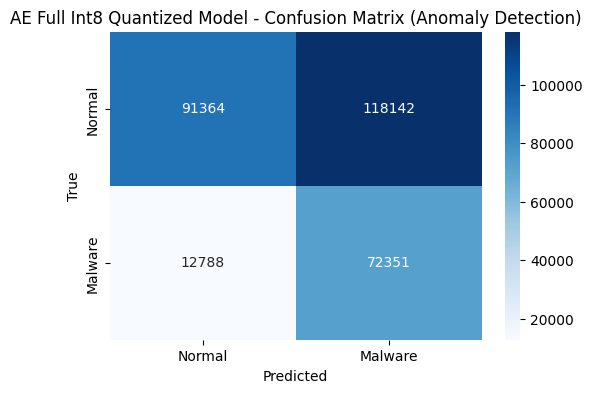

Accuracy: 0.35071357056797164
Classification Report:
              precision    recall  f1-score   support

      Normal       0.88      0.44      0.58    209506
     Malware       0.38      0.85      0.52     85139

    accuracy                           0.56    294645
   macro avg       0.63      0.64      0.55    294645
weighted avg       0.73      0.56      0.57    294645


TP, TN, FP, FN for Malware vs Benign:
True Positives (Malware predicted as ANY malware): 72351 (84.97985647000786% of Malware Identified)
True Negatives (Benign predicted as Benign): 91364
False Positives (Benign predicted as Malware): 118142 (56.39074775901406% of Benign Misclassified)
False Negatives (Malware predicted as Benign): 12788

--- Malware vs Benign Performance Metrics ---
Accuracy: 0.5556
Precision (Malware): 0.3798
Recall / Sensitivity (Malware): 0.8498
F1-Score (Malware): 0.5250
False Positive Rate (Benign misclassified): 56.39%
False Negative Rate (Malware missed): 15.02%
MLP Input Details: {'nam

/usr/local/lib/python3.12/dist-packages/tensorflow/lite/python/interpreter.py:457: UserWarning:     Warning: tf.lite.Interpreter is deprecated and is scheduled for deletion in
    TF 2.20. Please use the LiteRT interpreter from the ai_edge_litert package.
    See the [migration guide](https://ai.google.dev/edge/litert/migration)
    for details.
    
  warnings.warn(_INTERPRETER_DELETION_WARNING)


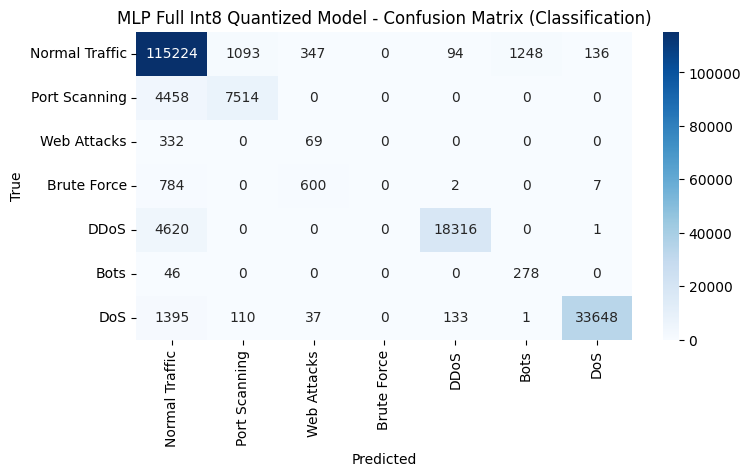

Accuracy: 0.9189261547668418
Classification Report:
                precision    recall  f1-score   support

Normal Traffic       0.91      0.98      0.94    118142
 Port Scanning       0.86      0.63      0.73     11972
   Web Attacks       0.07      0.17      0.09       401
   Brute Force       0.00      0.00      0.00      1393
          DDoS       0.99      0.80      0.88     22937
          Bots       0.18      0.86      0.30       324
           DoS       1.00      0.95      0.97     35324

      accuracy                           0.92    190493
     macro avg       0.57      0.63      0.56    190493
  weighted avg       0.92      0.92      0.92    190493

Total Mal: 72351 & 72351
Total Malware Samples: 72351
Total Benign Samples: 118142

TP, TN, FP, FN for Malware vs Benign:
True Positives (Malware predicted as ANY malware): 60716 (83.92% of Malware Identified)
True Negatives (Benign predicted as Benign): 115224 (97.53% of Benign Identified)
False Positives (Benign predicted as 

/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [ ]:
# --- Evaluate all AE → MLP TFLite models ---
for m in tflite_models:
    # --- Unpack model info ---
    ae_model_content = m["ae_model"]
    ae_name = m["ae_name"]

    mlp_model_content = m["mlp_model"]
    mlp_name = m["mlp_name"]

    print(f"\n--- Evaluating AE: {ae_name} → MLP: {mlp_name} ---")


    # --- Autoencoder ---
    ae_interpreter = tf.lite.Interpreter(model_content=ae_model_content)
    ae_interpreter.allocate_tensors()
    ae_input_details = ae_interpreter.get_input_details()[0]
    ae_output_details = ae_interpreter.get_output_details()[0]

    # Get scaling and zero point values foe quantising the input samples
    in_scale,  in_zp  = ae_input_details['quantization']
    out_scale, out_zp = ae_output_details['quantization']
    print(f"AE Input Details: {ae_input_details}")
    print(f"AE Output Details: {ae_output_details}")

   # --- Make new Thresholds for Full Int8 quantised model ---
    val_reconstructions = []
    # --- Get dequantised reconstruction for normal validation data ---
    for i in range(len(ae_X_val)):# Loop through the AE's validation dataset (contains only benign data)
        input_sample = np.expand_dims(ae_X_val[i].astype(np.float32), axis=0)

        # Quantise input
        if ae_input_details['dtype'] == np.int8:
            quant_input_sample = np.round((input_sample / in_scale) + in_zp).astype(np.int8)

        # Feed sample to model
        ae_interpreter.set_tensor(ae_input_details['index'], quant_input_sample)
        ae_interpreter.invoke()
        quant_output = ae_interpreter.get_tensor(ae_output_details['index'])

        # Dequantise output to FP32
        if ae_output_details['dtype'] == np.int8:
            output = (quant_output.astype(np.float32) - out_zp) * out_scale

        val_reconstructions.append(output[0])

    val_reconstructions = np.array(val_reconstructions)

    # --- Calculate per-feature reconstruction errors on normal data ---
    val_reconstruction_errors = np.abs(val_reconstructions - ae_X_val)

    # --- Define the new per-feature thresholds---
    mean_feature_errors = np.mean(val_reconstruction_errors, axis=0)
    std_feature_errors = np.std(val_reconstruction_errors, axis=0)
    new_per_feature_thresholds = mean_feature_errors + std_feature_errors

    threshold_file = os.path.join(dataset_path, "FULL_INT8_per_feature_Threshold.npy")
    np.save(threshold_file, new_per_feature_thresholds)
    print(f"Per-feature thresholds saved to: {threshold_file}")

    # --- AE Test Predictions of Test Sample ---
    ae_y_pred_probs = []
    for i in range(len(X_test)):
        input_sample = np.expand_dims(X_test[i].astype(np.float32), axis=0)
        if ae_input_details['dtype'] == np.int8:
            quant_input_sample = np.round(input_sample / in_scale + in_zp).astype(np.int8)

        ae_interpreter.set_tensor(ae_input_details['index'], quant_input_sample)
        ae_interpreter.invoke()
        quant_output = ae_interpreter.get_tensor(ae_output_details['index'])

        if ae_output_details['dtype'] == np.int8:
            output = (quant_output.astype(np.float32) - out_zp) * out_scale

        ae_y_pred_probs.append(output[0])

    ae_y_pred_probs = np.array(ae_y_pred_probs)

    # --- Anomaly Detection ---
    test_reconstruction_errors = np.abs(ae_y_pred_probs - X_test)
    ae_y_pred = (test_reconstruction_errors > (new_per_feature_thresholds)).any(axis=1).astype(int)
    malicious_pred_indices = np.flatnonzero(ae_y_pred)

    # --- Confusion Matrix ---
    y_test_binary = (y_test != 0).astype(int)# Convert y_test to binary for AE evaluation: 0 = Normal, 1 = Malware

    ae_cm = confusion_matrix(y_test_binary, ae_y_pred)# Compute AE's confusion matrix
    labels = ["Normal", "Malware"]

    # Plot heatmaps
    plt.figure(figsize=(6, 4))
    sns.heatmap(ae_cm, annot=True, fmt="d", cmap="Blues", xticklabels=labels, yticklabels=labels)
    plt.title(f"{ae_name} - Confusion Matrix (Anomaly Detection)")
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.show()

    # --- Accuracy & Classification Report ---
    print("Accuracy:", accuracy_score(y_test, ae_y_pred))
    print("Classification Report:")
    print(classification_report(y_test_binary, ae_y_pred, target_names=labels, labels=[0, 1]))


    # --- Malware vs Benign Metrics ---
    # Confusion matrix layout (for binary classification):
    # [[TN, FP],
    #  [FN, TP]]
    tn, fp, fn, tp = ae_cm.ravel()

    total_malware = tp + fn
    total_benign = tn + fp

    malware_identified = tp
    benign_misclassified = fp

    percentage_malware_identified = (malware_identified / total_malware * 100) if total_malware > 0 else 0
    percentage_benign_misclassified = (benign_misclassified / total_benign * 100) if total_benign > 0 else 0

    print("\nTP, TN, FP, FN for Malware vs Benign:")
    print(f"True Positives (Malware predicted as ANY malware): {tp} ({percentage_malware_identified}% of Malware Identified)")
    print(f"True Negatives (Benign predicted as Benign): {tn}")
    print(f"False Positives (Benign predicted as Malware): {fp} ({percentage_benign_misclassified}% of Benign Misclassified)")
    print(f"False Negatives (Malware predicted as Benign): {fn}")

    # --- Metrics ---
    accuracy = (tp + tn) / (tp + tn + fp + fn) if (tp + tn + fp + fn) > 0 else 0
    precision = tp / (tp + fp) if (tp + fp) > 0 else 0           # Precision for malware class
    recall = tp / (tp + fn) if (tp + fn) > 0 else 0              # Sensitivity / Recall for malware
    f1_score = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0
    fpr = (fp / (fp + tn)) * 100 if (fp + tn) > 0 else 0         # False Positive Rate (Benign misclassified)
    fnr = (fn / (fn + tp)) * 100 if (fn + tp) > 0 else 0         # False Negative Rate (Malware missed)

    # --- Print ---
    print("\n--- Malware vs Benign Performance Metrics ---")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision (Malware): {precision:.4f}")
    print(f"Recall / Sensitivity (Malware): {recall:.4f}")
    print(f"F1-Score (Malware): {f1_score:.4f}")
    print(f"False Positive Rate (Benign misclassified): {fpr:.2f}%")
    print(f"False Negative Rate (Malware missed): {fnr:.2f}%")


    # --- MLP --- #
    # Loads the TFLite model and gets it ready to make predictions
    mlp_interpreter = tf.lite.Interpreter(model_content=mlp_model_content) # Create interpreter object that will read and run the TFLite model
    mlp_interpreter.allocate_tensors() # Make the interpreter allocate memory
    mlp_input_details = mlp_interpreter.get_input_details()[0] # Get expected shape and data type of the data the model needs to evaluate (built-in method)
    mlp_output_details = mlp_interpreter.get_output_details()[0] # Shape and data type the model will need to produce the results in

    # Get scaling and zero point values for quantising the input samples
    mlp_in_scale, mlp_in_zp = mlp_input_details['quantization']
    mlp_out_scale, mlp_out_zp = mlp_output_details['quantization']
    print(f"MLP Input Details: {mlp_input_details}")
    print(f"MLP Output Details: {mlp_output_details}")


    # --- MLP Predictions ---
    mlp_y_pred_probs = []
    # Get samples the AE predicted as malicious as well as their true labels
    mlp_X_test = X_test[malicious_pred_indices]
    mlp_y_test = y_test[malicious_pred_indices]

    for i in range(len(mlp_X_test)):
        input_sample = np.expand_dims(mlp_X_test[i].astype(np.float32), axis=0)  # Reshape: (1, num_features)

        if mlp_input_details['dtype'] == np.int8:
            quant_input_sample = np.round(input_sample / mlp_in_scale + mlp_in_zp).astype(np.int8)

        mlp_interpreter.set_tensor(mlp_input_details['index'], quant_input_sample)
        mlp_interpreter.invoke()
        quant_output = mlp_interpreter.get_tensor(mlp_output_details['index'])

        if mlp_output_details['dtype'] == np.int8:
            output = (quant_output.astype(np.float32) - mlp_out_zp) * mlp_out_scale

        mlp_y_pred_probs.append(output[0])

    mlp_y_pred_probs = np.array(mlp_y_pred_probs)
    mlp_y_pred = np.argmax(mlp_y_pred_probs, axis=1) # Get final MLP predicttions


    # --- Confusion Matrix ---
    cm = confusion_matrix(mlp_y_test, mlp_y_pred)
    reverse_attack_type_map = {v: k for k, v in attack_type_map.items()}
    labels = [reverse_attack_type_map.get(i, f'Unknown {i}') for i in range(cm.shape[0])]

    # Create confusion matrix plot
    plt.figure(figsize=(8, 4))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=labels, yticklabels=labels)
    plt.title(f"{mlp_name} - Confusion Matrix (Classification)")
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.show()

    # Print accuracy & classification report
    print("Accuracy:", accuracy_score(mlp_y_test, mlp_y_pred))
    print("Classification Report:")
    print(classification_report(mlp_y_test, mlp_y_pred, target_names=labels))

    # Calculate malware vs benign sample metrics
    normal_traffic = attack_type_map.get('Normal Traffic', None)
    if normal_traffic is not None:

        total_benign = np.sum(cm[normal_traffic, :])
        benign_identified_correctly = cm[normal_traffic, normal_traffic] #TN
        benign_misclassified =  total_benign - benign_identified_correctly #FP

        mlp_tn = benign_identified_correctly
        mlp_fp = benign_misclassified

        total_malware = len(mlp_X_test) - total_benign
        print(f"Total Mal: {len(mlp_X_test) - total_benign} & {np.sum(cm) - np.sum(cm[normal_traffic, :])}")

        malware_identified_correctly = np.sum(np.diag(cm)) - cm[normal_traffic, normal_traffic]

        # Count all the malware samples identified even if misclassified as the wrong type of malware
        total_malware_identified = 0
        for i in range(len(labels)):
            if i != normal_traffic:  # skip the normal traffic row in the cm
                # for a row/class in the cm, count the samples from malware class that were predicted as ANY malware type (not benign)
                malware_predicted_as_any_malware = np.sum(cm[i, :]) - cm[i, 0] # Count all the samples in the row, minus the column of samples predicted as normal traffic
                total_malware_identified += malware_predicted_as_any_malware

        malware_misclassified = total_malware - total_malware_identified

        mlp_fn = malware_misclassified
        mlp_tp = total_malware_identified

        print(f"Total Malware Samples: {total_malware}")
        print(f"Total Benign Samples: {total_benign}")

        # --- Calculate and print TP, TN, FP, FN for Malware vs Benign ---
        print("\nTP, TN, FP, FN for Malware vs Benign:")
        print(f"True Positives (Malware predicted as ANY malware): {mlp_tp} ({(total_malware_identified/total_malware)*100:.2f}% of Malware Identified)")
        print(f"True Negatives (Benign predicted as Benign): {mlp_tn} ({(benign_identified_correctly/total_benign)*100:.2f}% of Benign Identified)")
        print(f"False Positives (Benign predicted as Malware): {mlp_fp} ({(benign_misclassified/total_benign)*100:.2f}% of Benign Misclassified)")
        print(f"False Negatives (Malware predicted as Benign): {mlp_fn} ({(malware_misclassified/total_malware)*100:.2f}% of Malware Misclassified)")

        print("\nPercentage of each Malware Class Correctly Identified:")
        for i, label in enumerate(labels):
            if i != normal_traffic: # Exclude 'Normal Traffic'
                correctly_identified = cm[i, i]
                total_in_class = np.sum(cm[i, :])
                percentage_identified = (correctly_identified / total_in_class) * 100 if total_in_class > 0 else 0
                print(f"{label}: {percentage_identified:.2f}%")

        # ---- Performance Metrics ---
        # Accuracy
        accuracy = (mlp_tp + mlp_tn) / (mlp_tp + mlp_tn + mlp_fp + mlp_fn) if (mlp_tp + mlp_tn + mlp_fp + mlp_fn) > 0 else 0
        # Precision (for malware class)
        precision = mlp_tp / (mlp_tp + mlp_fp) if (mlp_tp + mlp_fp) > 0 else 0
        # Recall / Sensitivity (for malware class)
        recall = mlp_tp / (mlp_tp + mlp_fn) if (mlp_tp + mlp_fn) > 0 else 0
        # F1-Score
        f1_score = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0
        # False Positive Rate (FPR)
        fpr = (mlp_fp / (mlp_fp + mlp_tn)) * 100 if (mlp_fp + mlp_tn) > 0 else 0
        # False Negative Rate (FNR)
        fnr = (mlp_fn / (mlp_fn + mlp_tp)) * 100 if (mlp_fn + mlp_tp) > 0 else 0

        print("\n--- Malware vs Benign Performance Metrics ---")
        print(f"Accuracy: {accuracy:.4f}")
        print(f"Precision (Malware): {precision:.4f}")
        print(f"Recall / Sensitivity (Malware): {recall:.4f}")
        print(f"F1-Score (Malware): {f1_score:.4f}")
        print(f"False Positive Rate (Benign misclassified): {fpr:.2f}%")
        print(f"False Negative Rate (Malware missed): {fnr:.2f}%")


